### Preamble

In [1]:
% matplotlib inline

In [2]:
from __future__ import unicode_literals, division

## Tile Model

In [3]:
from numpy import array, clip, copysign
from numpy.random import normal
from math import ceil
from collections import deque
from itertools import repeat, chain, cycle

# this object represents a tile in the grid
class Tile(object):
    def __init__(self, sym, pos, sugar, max_sugar = 100):        
        self.orig_sym = sym
        self.max_sugar = max_sugar
        self.sugar = 0 if sugar < 0 else max_sugar if sugar > max_sugar else sugar
        self.pollen = 0
        self.pos = pos   
        self.delay = 0

        self.season, self.cycle = None, None
        
    def __repr__(self):
        return 'Tile(pos={s.pos}, sugar={s.sugar})'.format(s=self)

    # TODO: intermediate colouring for autumn/spring
    @property
    def rgba(self):        
        a = self.sugar / self.max_sugar if self.max_sugar != 0 else 0
        r = int(255*a if self.max_sugar < 0 else 0)
        if self.season in ('spring', 'summer'):
            g, b = int(255*a if self.max_sugar > 0 else 0), 0
        elif self.season in ('autumn', 'winter'):
            g, b = 0, int(255*a if self.max_sugar > 0 else 0)
        else:
            g, b = 0, 0 
        return '{r},{g},{b},{a}'.format(r=r, g=g, b=b, a=a)
    
    # TODO: use background color in addition/in place of opacity for Tile health
    @property
    def sym(self):
        return '<span style="color: rgba({s.rgba})">{s.orig_sym}</span>'.format(s=self)
        
    def harvest(self, sugar=1):
        if self.sugar == 0:
            self.delay = int(clip(self.delay*2, 10, 100))
            # self.max_sugar -= 5
            return 0
        sugar = int(clip(sugar, 0, self.sugar))
        self.sugar -= sugar        
        return sugar

    # TODO: add a "sprouting" functionality
    def step(self, grid, num):
        
        if self.season is None:
            lenx, leny = grid.shape
            equator = leny // 2
            north_hemi = xrange(0, equator+1)
            longitude, latitude = self.pos
            if latitude in north_hemi:
                self.cycle = cycle(chain(
                    repeat('spring', 30),
                    repeat('summer', 20),
                    repeat('autumn', 30),
                    repeat('winter', 20), ))
            else:
                self.cycle = cycle(chain(
                    repeat('autumn', 30),
                    repeat('winter', 20), 
                    repeat('spring', 30),
                    repeat('summer', 20), ))
        
        self.season = next(self.cycle) # change the season
        
        if self.delay:
            growth = 0
            self.delay -= 1            
        elif self.season == 'spring':
            #int(copysign(normal(0,.05*abs(self.sugar)+.75), self.max_sugar))
            growth = self.max_sugar//40
            if growth < 2:
                growth = 2
        elif self.season == 'summer':
            #int(copysign(normal(0,.03*abs(self.sugar)+.5), self.max_sugar))
            growth = self.max_sugar//50 
            if growth < 1:
                growth = 1
        elif self.season == 'autumn':
            growth = 0
        elif self.season == 'winter':
            growth = -self.max_sugar//30
            self.pollen = 0
        
        # XXX: only handles positive sugar amounts (no poison)
        if growth > 0 and self.sugar + growth > self.max_sugar:
            self.pollen += growth * 2
        else:
            self.sugar += growth
            
        if self.pollen > self.max_sugar:
            surrounding = radius(grid, self.pos, 2)
            num_tiles = sum(len(side) for side in surrounding)
            for side in surrounding:
                for tile in side:
                    if (tile.max_sugar <= self.max_sugar and 
                        tile.max_sugar + self.pollen // num_tiles >= self.max_sugar):
                        tile.orig_sym = self.orig_sym
                        
                    tile.max_sugar += self.pollen // num_tiles
            self.pollen = 0

def make_grid(grid, legend, agents):
    grid = grid.strip()
    g = []
    a = {}
    for row in grid.split('\n'):
        if row.strip():
            g.append([])
            for col in row.strip():
                col = col.strip()
                if col:
                    pos = len(g[-1]), len(g)-1
                    if col in legend:
                        sym = col
                    elif col in agents:
                        a[col] = pos
                        sym = '.'
                    else:
                        sym = '.'
                    sugar = legend.get(sym, 0)
                    g[-1].append(Tile(sym, pos, sugar, max_sugar=sugar))
                
    return array(g).T, a

### Radius & Density Grid Functions

In [4]:
%load_ext cython

In [5]:
%%cython

from numpy import zeros_like, empty_like, zeros
from numpy import clip, array, sqrt

def distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return sqrt((x1-x2)**2 + (y1-y2)**2)  

def manhattan_distance(pos1, pos2):
    x1, y1 = pos1
    x2, y2 = pos2
    return abs(x2 - x1) + abs(y2 - y1)


def radius(g, pos, r):
    if r == 0:
        return [g[pos]],
    
    x, y = pos
    
    minx, miny = 0, 0
    maxx, maxy = len(g) - 1, len(g[0]) - 1

    #xvmin, xvmax = clip(x-r, minx, maxx), clip(x+r, minx, maxx)
    #yvmin, yvmax = clip(y-r, miny, maxy), clip(y+r, miny, maxy)
    
    xvmin, xvmax = x-r, x+r
    yvmin, yvmax = y-r, y+r
    
    if xvmin < minx: xvmin = minx
    elif xvmin > maxx: xvmin = maxx
    
    if xvmax < minx: xvmax = minx
    elif xvmax > maxx: xvmax = maxx
        
    if yvmin < miny: yvmin = miny
    elif yvmin > maxy: yvmin = maxy
        
    if yvmax < miny: yvmax = miny
    elif yvmax > maxy: yvmax = maxy     

    top = g[xvmin:xvmax+1, yvmax]
    bot = g[xvmin:xvmax+1, yvmin]
    lef = g[xvmin, yvmin+1:yvmax]
    rgt = g[xvmax, yvmin+1:yvmax]
    
    return top, rgt, bot, lef

def density(g, agents=None):
    Tile = type(g[0,0])
    d = zeros_like(g)

    agent_loc = empty_like(g, dtype=object)
    for agent in agents if agents is not None else []:
        if not agent_loc[agent.pos]:
            agent_loc[agent.pos] = []
        agent_loc[agent.pos].append(agent)
        
    for x, col in enumerate(g):
        for y, row in enumerate(col):
            t = g[x,y]
            d[x, y] = Tile(t.sym, t.pos, t.sugar, t.max_sugar)
            
            for agent in agent_loc[x,y] or []:
                d[x, y].sugar -= agent.metabolism
                d[x, y].max_sugar -= agent.metabolism
                
            for r in [1, 2]:
                sides = radius(g, (x,y), r)
                sugar = sum(tile.sugar for side  in sides
                                       for tile in side) // ((r+2)**2)
                
                agent_sides = radius(agent_loc, (x,y), r)
                metabolism = sum(agent.metabolism for side in agent_sides
                                                  for group in side 
                                                  for agent in (group or [])) // (r**2)                
                
                d[x, y].sugar += sugar - metabolism
                d[x, y].max_sugar += sugar - metabolism
            
            # fuzz these values
            d[x ,y].sugar = d[x ,y].sugar // 4 * 4
            d[x ,y].max_sugar = d[x ,y].max_sugar // 4 * 4

    return d

## Agent Model

In [6]:
from __future__ import unicode_literals
from numpy import sign, ceil, clip, empty, argmax, zeros_like
from collections import deque, namedtuple
from numpy.random import random
from operator import attrgetter


Heartbeat = namedtuple('Heartbeat', 'sugar max_sugar metabolism wealth season pos')

class Agent(object):
    def __init__(self, name, sym, metabolism, wealth, vision, greed, cognition, pos, parent=None):
        if wealth <= 0:
            raise ValueError('initial wealth must be > 0')
        
        self.name = name
        self.orig_sym = sym
        self.metabolism = metabolism
        self.init_wealth = self.wealth = wealth
        self.vision = vision
        self.greed = greed
        self.cognition = cognition
        self.init_pos = self.pos = pos
        
        self.messages = deque(['Was just born!'])
        self.record_message = lambda _: None #messages.append
        self.retrieve_message = lambda _: None #messages.pop
        self.vitals = []
        
        self.max_tiles = set()
        self.child_tiles = set()
        
        self.children = []
        self.parent = parent
        
        self.has_shared, self.has_fought, self.has_reproduced = 0, 0, 0
        
        self.visited = None
        
        self.friends = set()
        self.enemies = set()
       
    def __repr__(self):
        return unicode(self).encode('utf-8')
    
    # TODO: color code agents (based on wealth?)
    def __unicode__(self):
        return 'Agent({s.name}, {s.sym}, {s.metabolism}, {s.wealth}, {s.vision}, {s.pos})'.format(s=self)
    
    @property
    def sym(self):
        r = 255//3 * self.has_fought
        g = 255//3 * self.has_shared 
        b = 255//3 * self.has_reproduced 
        rgba = '{r},{g},{b},{a:.4f}'.format(r=r, g=g, b=b, a=clip(self.wealth/self.init_wealth, 0, 1))
        return '<span style="color: rgba({rgba})">{sym}</span>'.format(rgba=rgba, sym=self.orig_sym) if self.alive else '†'
    
    @property
    def alive(self):
        return self.wealth >= 0
    
    @property
    def age(self):
        return sum(1 for hb in self.vitals if hb.wealth >= 0)
    
    def reproduce(self):
            child = Agent(name = "{}'s child".format(self.name),
                    sym = self.orig_sym,
                    metabolism = self.metabolism,
                    wealth = self.wealth//4,
                    vision = self.vision ,
                    greed = self.greed,
                    cognition = self.cognition,
                    pos = self.pos,
                    parent = self)            
            self.children.append(child)
            self.wealth -= self.wealth//4 

            return child
    
    def eat(self, metabolism, tile):
        if self.wealth < 10:
            hunger = 10
        else:
            hunger = (self.metabolism / self.wealth) * self.init_wealth * self.greed
        
        sugar = tile.harvest(int(metabolism*hunger))
        self.wealth += sugar

        return sugar
    
    def step(self, grid, density_grid, friend_grid, enemy_grid, other_agents, step):
        if self.has_shared: self.has_shared -= 1
        if self.has_fought: self.has_fought -= 1
        if self.has_reproduced: self.has_reproduced -= 1
        
        season = grid[self.pos].season
        metabolism_mult = {'summer': .75, 'winter': 1.25, 
                           'spring':  .5, 'autumn':    1}
        
        metabolism = int(ceil(metabolism_mult.get(season, 1) * self.metabolism * self.age / 250))
        
        if not self.alive:
            self.vitals.append(Heartbeat(None, grid[self.pos].sugar, metabolism, self.wealth, season, self.pos))
            self.record_message('Rests in peace')
            return
        
        if (self.age > 150 and
            self.wealth > 50 and
            self.wealth > (self.init_wealth * .5) and
            (grid[self.pos] in self.max_tiles
                or
            grid[self.pos] in self.child_tiles)
            and choice([True] + [False]*9) ):
            child = self.reproduce()
            self.child_tiles.add(grid[self.pos])
            self.has_reproduced = 3
            child.has_reproduced = 3
                
        for r in (0,1,2):
            for side in radius(grid, self.pos, r):
                for tile in side:
                    if len(self.max_tiles) < 10:
                        self.max_tiles.add(tile)
                    else:
                        min_tile = min(self.max_tiles, key=lambda t: t.sugar)
                        if tile.sugar > min_tile.sugar:
                            self.max_tiles.remove(min_tile)
                            self.max_tiles.add(tile)
        
        for other in other_agents:
            if other is not self and other not in self.friends and other not in self.enemies:
                if other.parent in self.friends or other.parent is self:
                    self.friends.add(other)
                elif other.parent in self.enemies:
                    self.enemies.add(other)
                else:
                    self.enemies.add(other)
                    
        sugar = 0
        if not self.parent or self.age > 100:
            sugar = self.eat(metabolism, grid[self.pos])
        
        self.wealth -= metabolism
        
        ### determine movement ###
        
        minx, miny = 0, 0
        maxx, maxy = grid.shape
        
        # look around
        x, y = self.pos
        
        # vision-adjusted minima, maxima
        xvmin, xvmax = clip(x-self.vision,   minx, maxx), clip(x+self.vision+1, minx, maxx) 
        yvmin, yvmax = clip(y-self.vision,   miny, maxy), clip(y+self.vision+1, miny, maxy)
        
        view = empty((xvmax - xvmin, yvmax - yvmin), dtype=float)
        vminx, vminy = 0, 0
        vmaxx, vmaxy = view.shape
        
        for x in xrange(xvmin, xvmax):
            for y in xrange(yvmin, yvmax):
                view[x-xvmin, y-yvmin] = density_grid[x,y].sugar
        
        for other in other_agents:
            if self is not other:
                ox, oy = other.pos
                ovx, ovy = ox - xvmin, oy - yvmin

                for r in (0,1,2):
                    ovxmin, ovxmax = clip(ovx-r, vminx, vmaxx), clip(ovx+r+1, vminx, vmaxx)
                    ovymin, ovymax = clip(ovy-r, vminy, vmaxy), clip(ovy+r+1, vminy, vmaxy)

#                     if other in self.enemies:
#                         view[ovxmin:ovxmax, ovymin:ovymax] *= 5 #// ((r+1)**2) 
#                     elif other in self.friends:
#                         view[ovxmin:ovxmax, ovymin:ovymax] *= 5 #// ((r+1)**2)

        sx, sy = self.pos
        svx, svy = sx - xvmin, sy - yvmin
                    
        for r in xrange(0,self.vision):
            svxmin, svxmax = clip(svx-r, vminx, vmaxx), clip(svx+r+1, vminx, vmaxx)
            svymin, svymax = clip(svy-r, vminy, vmaxy), clip(svy+r+1, vminy, vmaxy)
            view[svxmin:svxmax, svymin:svymax] *= (.95 **r) 
            
        view *= 1 + (.5 - random(view.shape) / 100)
        
        if self.visited is None:
            self.visited = zeros_like(grid, dtype=float) -1
        self.visited[self.pos] *= 2
        view += self.visited[xvmin:xvmax, yvmin:yvmax]
            
#         size, _     = view.flatten().shape
#         max_value   = max(view)
#         max_values  = view.flatten() == max_value
#         max_indices = arange(size)[max_values]
#         t           = choice(max_indices)
        
        t = argmax(view)
        
        tx, ty = t % vmaxx, t // vmaxx
        tx += xvmin
        ty += yvmin
        
        d = { ( 0, 0): '*',
              ( 0,-1): 'n', 
              ( 1,-1): 'ne', 
              ( 1, 0): 'e',
              (-1, 1): 'se',
              ( 0, 1): 's',
              ( 1, 1): 'sw',
              (-1, 0): 'w',
              (-1,-1): 'nw', }[sign(tx - x), sign(ty - y)]
        
        #self.record_message('Sees max sugar ({}) to the {} at ({}, {})'.format(t.sugar, d, tx, ty))
        
        x, y = self.pos
        
        if not self.parent or self.age > 100:
             #if grid[self.pos].sugar < 5:   
            self.pos = x + sign(tx - x), y + sign(ty - y)
        
        for child in self.children:
            if child.alive and distance(self.pos, child.pos) > self.vision:
                cx, cy = child.pos
                self.pos = x + sign(cx - x), y + sign(cy - y)
                break


        self.pos = tuple(clip(self.pos, (minx,miny), (maxx-1,maxy-1))) # clip to the grid

        self.vitals.append(Heartbeat(sugar, grid[self.pos].sugar, metabolism, self.wealth, season, self.pos))
        if self.wealth > 10:
            self.record_message('Fit as a Fiddle ({})'.format(self.wealth))
        elif self.wealth > 5:
            self.record_message('Healthy ({})'.format(self.wealth))
        elif self.wealth > 1:
            self.record_message('Hanging On ({})'.format(self.wealth))

### Display Frame & Simulate

In [7]:
from __future__ import unicode_literals
from IPython.display import display_html, clear_output
from scipy.spatial import cKDTree as KDTree
from time import sleep, time
from numpy import array
from numpy.random import shuffle
from collections import deque
from __builtin__ import any # pylab clobbered `any`

def display_frame(step, grid, agents, show_messages=True):
    template = '''
        <div style="font-family: monospace;">
            <h2>Step #{{step}}</h2>
            <div style="float: left; padding: .5em; margin: 0 .5em 0 .5em; border: 1px solid #aeaeae;">
                <pre>{{grid}}</pre>
            </div>

            {message_panel}
        </div>
        '''.format(message_panel = '''
            <div style="margin: 0 1em 0 1em;">
                 <p>== messages ==</p>
                 <p>{messages}</p>
            </div>''' if show_messages else '' )

    agent_pos = {agent.pos: agent for agent in agents}
    
    output = []
    for y, row in enumerate(grid.T):
        output.append([])
        for x, col in enumerate(row):
            agent = agent_pos.get((x,y))
            if agent is not None:
                output[-1].append(agent.sym)
            else:
                output[-1].append(col.sym)
    
    messages = []
    if show_messages:
        for agent in agents:
            while agent.messages:
                messages.append('{}: {}'.format(agent.orig_sym, agent.messages.popleft()))
    
    return template.format(step=step,
                           grid='\n'.join(' '.join(row) for row in output), 
                           states='', 
                           messages='</p><p>'.join(messages))

def simulate(grid, agents, steps=100, stop_early=True):
    density_grid = enemy_grid = friend_grid = density(grid, agents)
    density_grids = deque([(enemy_grid, friend_grid, density_grid)] * 10)
    
    dead_agents = {}
    agents = array(agents) # use numpy array for added convenience
    
    for step in xrange(steps):
        start_time = time()
        
        for col in grid:
            for tile in col:
                tile.step(grid, step)
    
        density_grid = enemy_grid = friend_grid = density(grid, agents)
        density_grids.appendleft((enemy_grid, friend_grid, density_grid))        
        
        # keep only 5 entries; discard the rest
        while len(density_grids) > 16:
            density_grids.pop()
        
        if len(agents):
            shuffle(agents)
                
            kdt = KDTree([agent.pos for agent in agents])

            for agent in agents:
                density_grid, enemy_grid, friend_grid = density_grids[agent.cognition ** 2]

                other_agents = agents[kdt.query_ball_point(agent.pos, agent.vision)]
                agent.step(grid, density_grid, friend_grid, enemy_grid, other_agents, step)

            for agent in agents:
                if not agent.alive:
                    if agent not in dead_agents:
                        dead_agents[agent] = 0
                    dead_agents[agent] += 1

            agents = array([
                agent for agent in         
                set(agents) | set(child for agent in agents for child in agent.children)
                if dead_agents.get(agent,0) < 25
            ])
        
        clear_output(wait=True)
        display_html(display_frame(step, grid, agents, False), raw=True)
        
        if stop_early and not any(agent.alive for agent in agents):
            return step+1

        elapsed = time() - start_time
        if .1 > elapsed:
            sleep(.1 - elapsed)
    
    return step+1

In [8]:
from numpy import array
#from random import randrange
from numpy.random import randint as randrange

class nearestdict(dict):
    def __missing__(self, key):
        new_key = min(self, key=lambda k: abs(k-key))
        return self[new_key]

# self, sym, pos, sugar, max_sugar = 100)
def random_grid(maxx, maxy, legend):
    
    reverse_legend = nearestdict({v:k for k,v in legend.items()})
    
    grid = []
    for x in xrange(maxx):
        grid.append([])
        for y in xrange(maxy):
            sugar = max_sugar = randrange(1,10+1)
            grid[x].append(Tile(reverse_legend[sugar], (x,y), sugar, max_sugar))
    
    grid = array(grid)
    
    for _ in xrange(randrange(5,10+1)):
        x, y = randrange(0,maxx), randrange(0,maxy)
        for r in xrange(randrange(2,5+1)):
            for side in radius(grid, (x,y), r):
                for tile in side:
                    sugar = randrange(10,30)
                    tile.sugar = tile.max_sugar = sugar
                    tile.orig_sym = reverse_legend[sugar]
    
    return grid    

## Simulation Inputs & Run

In [9]:
from itertools import count
from collections import defaultdict
counter = defaultdict(count().next)

def all_agents(agents):
    for agent in agents:
        yield agent
        for child in all_agents(agent.children):
            yield child
            
    
def print_agents(agents):
    row = ('{id:^3} {sym:^5} {age:^5} {children:^5} {name:<20} ' 
           '{init:^4}/{wealth:^5} {greed:^6} {metabolism:^6} '
           '{vision:^7} {cognition:^5} {pos:^10} {fe:^2}')

    print row.format(id='id', sym='sym', age='age', children='chd', name='name', 
                     metabolism='metab', init='init', wealth='wealth', vision='vision', 
                     greed='greed', cognition='cogn', pos='pos', fe='fe')

    for agent in all_agents(agents.values()):
        print row.format(id=counter[agent],
                         sym=agent.orig_sym, 
                         age=agent.age,
                         children=len(agent.children),
                         name=agent.name[:15] + ('...' if len(agent.name) > 15 else ''),
                         metabolism=agent.metabolism,
                         init=agent.init_wealth,
                         wealth=agent.wealth,
                         vision=agent.vision,
                         greed=agent.greed,
                         cognition=agent.cognition,
                         pos='({p[0]:2d}, {p[1]:2d})'.format(p=agent.pos),
                         fe='{}/{}'.format(
                            ''.join(x.orig_sym for x in agent.friends),
                            ''.join(x.orig_sym for x in agent.enemies))   )


In [10]:
from __future__ import unicode_literals
from random import choice, randrange

# TODO: add some randomisation to the world

grid_input = '''
@.... ..... ..... ..... ....@
..... ..... ..... ..... .....
☢☢☢☢. ..... ::::: ::::: .....
☢☢☢☢. ..... ::::: ::::: .....
..... ..... ..... ::::: .....

♛.... ..... ..... ..... ....;
..... ..... ..... ☠...@ ....;
..... ::::: ..... ..... ....;
..... ::::: ..... ..... ....;
..... ::::: ..... ..... ....;

..... ..... ..... ..... ☪...;
..... ..... ..☢.. ..... ....;
@.... ..... .☢☢☢. ..... ....;
..... ..... ..☢.. ..... ....;
..... ..... ..... ..... ....;

..... ::::: ..... ..... .....
♚.... ..... ..... ..... .☢☢☢☢
..... ::::: ..... ..@.. .☢☢☢☢
..... ..... ..... ..... .....
..... ::::: ..... ..... .....

.☢☢☢☢ ☢.... ..... ..... :::::
..... ☢.... ..@.. ..... :::::
☢☢☢☢. ☢.... ..... ..... .....
@@@☢. ☢.... ..... ..♿.. .....
@@@@. ☢.... ..... ..... .....
'''

grid_legend = {
    '☢':     0,
    '.':     1,
    ':':    20,
    ';':    30,
    '@':    50,
}

#agent_symbols = '♛☠☪♚♿'
agent_symbols = ('♛♜'
                 '☀☁☂☃☄★☆☊☋☎☏☘☚☛☠☡☢☣☩☪'
                 #'☫☬☭☮☯☸☹☺☻☼☽☾☿♀♁♂♃♄♅♆'
                 '♇♔♕♖♗♘♙♚♝♞♟♠♡♢♣♤♥♦'
                 #'♧♨♩♪♫♬♰♱♲♺♻♼♽♾♿⚀⚁⚂⚃⚄'
                 #'⚅⚆⚇⚈⚉⚐⚑⚒⚔⚕⚖⚗⚘⚙⚚⚛⚜⚠⚱'
                )

#grid, agent_pos = make_grid(grid_input, grid_legend, agent_symbols)
grid, agent_pos = random_grid(35, 25, {'.': 0, '↟': 20}), {}

def random_pos(grid):
    x = randrange(0, len(grid))
    y = randrange(0, len(grid[0]))
    return x, y

# TODO: better distribution for random wealth, metabolism, vision

agents = {}
for sym in agent_symbols:
    agents[sym] = Agent('', sym, metabolism = 1,   #choice([1,2,3]),                                  
                                 wealth     = 100, #randrange(50,100), 
                                 vision     = randrange(5,35),
                                 greed      = choice([1,2,3,4,5]),
                                 cognition  = 0,   #choice([0,1,2,3]),
                                 # TODO: friendliness - probability of making friends
                                 # TODO: aggression - probability of making enemies
                                 # TODO: strength - likelihood of winning a fight
                                 # TODO: reproduction - likelihood of reproducing
                                 pos        = agent_pos.get(sym, random_pos(grid)))

# def __init__(self, name, sym, metabolism, wealth, vision, pos):
#agents = {
#    '♛': Agent('Martina the Princess','♛', 2, 100, 50, agent_pos.get('♛', random_pos(grid))),
#    '☠': Agent('The Evil Pirate',     '☠', 2, 100, 10, agent_pos.get('☠', random_pos(grid))), 
#    '☪': Agent('Murat',               '☪', 2, 100, 50, agent_pos.get('☪', random_pos(grid))),
#    '♚': Agent('Hansi',               '♚', 2, 100, 10, agent_pos.get('♚', random_pos(grid))),
#    '♿': Agent('Juergen',             '♿', 2, 100, 50, agent_pos.get('♿', random_pos(grid))),
#}

print_agents(agents)

id   sym   age   chd  name                 init/wealth greed  metab  vision  cogn     pos     fe
 0    ☁     0     0                        100 / 100    1      1       8      0    (27, 21)  / 
 1    ☀     0     0                        100 / 100    1      1      21      0    (15,  2)  / 
 2    ☃     0     0                        100 / 100    2      1      24      0    (32, 19)  / 
 3    ☂     0     0                        100 / 100    2      1      29      0    (14,  1)  / 
 4    ★     0     0                        100 / 100    4      1       7      0    (14, 23)  / 
 5    ☄     0     0                        100 / 100    4      1      16      0    ( 8, 23)  / 
 6    ☆     0     0                        100 / 100    4      1      13      0    ( 4, 20)  / 
 7    ☋     0     0                        100 / 100    3      1      30      0    (21,  7)  / 
 8    ☊     0     0                        100 / 100    4      1      21      0    (16,  7)  / 
 9    ☏     0     0                    

In [11]:
% time simulate(grid, agents.values(), steps=500, stop_early=False)

print_agents(agents)

Step #499 
 
 . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . . . ↟ ↟ ↟ ↟ ↟ 
 . . . . . . . . . . . ↟ ↟ ↟ . ↟ . . . ↟ . ↟ ↟ ↟ . . . . . . . ↟ ↟ ↟ ↟ 
 . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ☊ ↟ ↟ . ↟ ↟ ↟ ↟ ↟ ↟ . . . ↟ . ↟ ↟ ↟ ↟ ↟ 
 . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ . . ↟ ↟ ↟ ↟ ↟ . ↟ ↟ . . ↟ . ↟ ↟ ↟ ↟ ↟ 
 . . . . . . . . . ↟ . ↟ ↟ ↟ ↟ ↟ ↟ . . ↟ . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ 
 . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ . . . . . . . . ☆ . . ↟ . ↟ ↟ ↟ ↟ ↟ 
 . . . . . . . . . . . ↟ ↟ ↟ . ↟ ↟ . ♘ . . . . . . . . . . ↟ . . ↟ ↟ . 
 . . . . . . . . . . . . . . ↟ ↟ ↟ . . . . . . ☎ . . . . . . . . ↟ . . 
 . . . . . . . . . . . . ↟ . ↟ . ↟ . . . . . . . . . . . . . ↟ . . . . 
 . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . . . . . . . . . . . . . . . . . 
 . . . . . . . ↟ ↟ ↟ ↟ . ↟ ↟ ↟ ↟ ↟ . ↟ . . . . . . . . . . . . . . . . 
 . . . . . . ↟ . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . ♥ . . . . . . . . . . . . . . . . 
 . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . ♖ . . . . . . . . . . . . . . . . . 
 . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . . . . . . . . . ☩ ↟ . ↟ . . . . 
 . . . . . . ↟ . ↟ ↟ ↟ ♖ ↟ ↟ ↟ . . . . . . . . . . . . . ↟ . . ↟ ↟ . . 
 . . . . . . . . ↟ . ↟ ↟ ↟ ↟ ↟ . ↟ . . . . . . . . . . . . ↟ ↟ ↟ ↟ . ↟ 
 . . . . . . . . ↟ . . . ↟ . . . . . . . . . . . . . . . . ↟ . ↟ ↟ ↟ ↟ 
 . . . . . . . . . ↟ ↟ ↟ . . . . ↟ . . . . . . . . . . . † ↟ ↟ ↟ ↟ . ↟ 
 . . . . . . . . . . . . . . . . . . . . . . . . . . . ↟ . ↟ ↟ ↟ ↟ ↟ ↟ 
 . . . . . . . . . . . . . . . . . ☚ . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ 
 ↟ . ↟ . . . . . . . . . . . . . . . . . . . . . . . . . . . ↟ ↟ ↟ . ↟ 
 ↟ . ↟ ↟ . . . . . . . . . . . . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ 
 ↟ ♗ . ↟ . . . . . . . . . . . . . ☄ . . . . . . . . . ↟ . . ↟ ↟ ↟ ↟ ↟ 
 ↟ . ↟ . . . . . . . . . . . . . . . . . . . . . . . . ↟ . ↟ ↟ ↟ ↟ ↟ ↟ 
 ↟ ↟ ↟ . . . . . . . . . . . . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟

CPU times: user 36 s, sys: 254 ms, total: 36.3 s
Wall time: 52.1 s
id   sym   age   chd  name                 init/wealth greed  metab  vision  cogn     pos     fe
 0    ☁    345    0                        100 / -1     1      1       8      0    (30, 22)  /♘♙☃♚♛♞♟☀♡☄♢♣♜♤♥♦☊☋♠☏☘☚☠☡☢☩☪♇♔☂
 1    ☀    286    0                        100 / -2     1      1      21      0    (19,  1)  /♗♘♙☃♚♝♛♞♟♠♡☄☂♣♜♤★♖♦☊♥♖☋☎☏☘☚☛☆☠☡☁☢☣☩☪♇♔♢♕♖
 2    ☃    200    0                        100 / -1     2      1      24      0    (22,  3)  /♗♘♙♚♝♞♛♟♠☁☄♢♣♜♤♥♦☊★☋☎☀☏☘☚☛☆☠☡♡☢☣☩☪♇♔☂♕♖
 3    ☂    193    0                        100 / -1     2      1      29      0    (22,  1)  /♗♘♙☃♚♝♞♛♟☀♡♤♢♣♜☄★☆☊♥☋☎♠☏☘☚☛♦☠☡☁☢☣☩☪♇♔♕♖
 4    ★    186    0                        100 / -1     4      1       7      0    ( 4, 21)  /♗☃♚♝♛♞♟♠♡♢♣♜☄☆☊☋☎☏☘☚♦☠☡☢☣☪♔♕♖
 5    ☄    500    2                        100 / 124    4      1      16      0    (17, 22)  ☄☄/♘♗♘♤♙☃♤♚♖♝♛♞♤♟♠♡♘♖♢♣♜♖♤★♖☆☊♥♖☋☎☀☏☘☚☛♦☠☡☁☢☣☩☪♇♔☂♕♖♤
40    ☄    40     0   's child      

In [12]:
display_html(display_frame(0, grid, agents.values(), False), raw=True)

Step #0 
 
 ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . . . . . . . . . . . . . . . . . . . . ♡ ↟ ↟ ↟ ↟ ↟ ↟ 
 ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . . . . ♦ . . . . . . . . ☀ . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ 
 ↟ ↟ ☁ ↟ . ↟ ↟ . . . . ☃ . . . . . . . . . . . . . . . . ↟ ↟ . ↟ ↟ ↟ . 
 ↟ ↟ ↟ ↟ ♗ ♇ ↟ . . . . . . . . . . . . ☂ . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ 
 ↟ ↟ ♕ ↟ ↟ ↟ ↟ . ☄ . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ . ↟ ☆ ↟ ↟ ↟ ☎ ↟ 
 ↟ ↟ ↟ ↟ . ↟ ↟ . . . . . . . . . . . . . . . ↟ ↟ . ↟ ↟ . ↟ ↟ ↟ ↟ ↟ ↟ ↟ 
 ↟ ☋ ↟ ↟ ↟ ☚ ↟ . . . . . . . ☣ . . . . . . . ↟ ↟ ↟ ↟ ↟ . ↟ . ↟ ↟ ↟ ↟ ↟ 
 . . . . . . . . . . . . . . ↟ . ↟ . . . . . ♟ ↟ ↟ ↟ ↟ . . . . . . . . 
 . ★ . . . . . . . . . . . . ↟ ↟ ↟ . . . ☠ . ↟ ↟ ↟ ↟ ↟ . . . . . . . . 
 . . . . . . . . . . ☊ . . . ↟ ↟ ↟ . . . . . . . . . ☡ . . . . . . . . 
 . . . . . . . ♥ . . . . . . . . . . . . . . . . . . ♠ . . . . . . . . 
 ☪ . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
 ☩ . . . . . . . . . . . . . . . ♛ . . . . . . . . . . . . . . . . . . 
 . . . . . . . . . . . . . . ↟ ↟ . ↟ ↟ ↟ ↟ ↟ ♢ . . . . . . . . . . . . 
 . . . . ♜ . . . . . . . . . ↟ ↟ ↟ ↟ . ♖ ↟ ↟ ↟ . . . . . . . . ♘ ♔ . . 
 . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . ↟ ↟ ↟ . . . . . . . 
 . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . ↟ ↟ ↟ . . ☢ . . . . 
 ☏ . . . ♞ . . . . . . . . . ↟ ↟ ♝ ↟ ☛ ↟ ☘ ↟ ↟ . . ↟ ↟ ↟ . . . . . . . 
 . . . . . . . . . . . ♙ . . ↟ . ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . . . . . . . . . . . 
 . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . . . . . . . . . . . . 
 . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ♣ ↟ ↟ . ↟ . . . . . . . . . . . . 
 . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ ↟ . ↟ ↟ ↟ ↟ . . . . . . . 
 . . . . . . . . . . . . . . . . . . . . . . . ↟ ↟ ↟ ↟ ↟ . . . . . . . 
 . . ♚ . . . . . . . . . . . . . ↟ ↟ ↟ . . . . . ↟ ↟ ↟ ↟ . . . . . . . 
 . . . . . . . . . . . . . ♤ . . ↟ ↟ ↟ . . . . ↟ ↟ ↟ ↟ ↟ . . . . . . .

## Plotting & Analysis

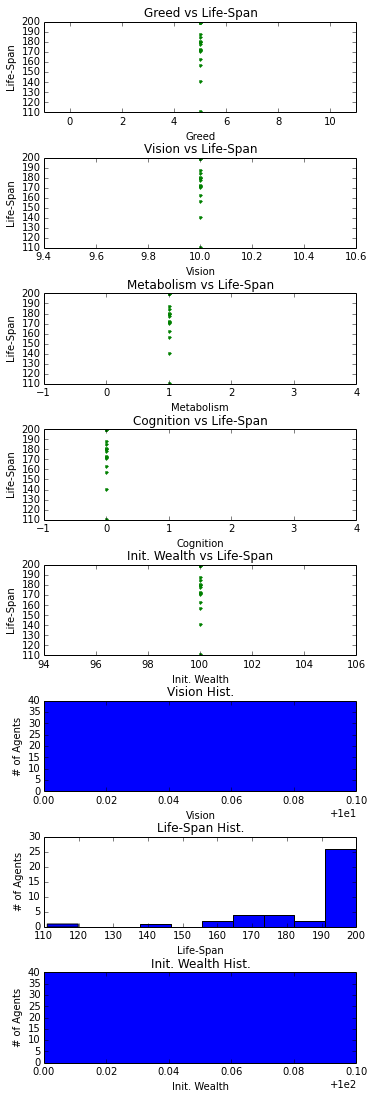

In [16]:
from matplotlib.pyplot import subplots, subplots_adjust

data = []
for agent in agents.values():
    data.append((agent.greed, agent.cognition, agent.vision, agent.metabolism, agent.init_wealth, 
                 sum(1 for hb in agent.vitals if hb.wealth > 0)))

greed       = [g  for g, c, v, m, w, ls in data]
vision      = [v  for g, c, v, m, w, ls in data]
cognition   = [c  for g, c, v, m, w, ls in data]
metabolism  = [m  for g, c, v, m, w, ls in data]
life_span   = [ls for g, c, v, m, w, ls in data]
init_wealth = [w  for g, c, v, m, w, ls in data]

fig, axes = subplots(8, figsize=(5,15))

fig.tight_layout()

axes = iter(axes)

ax = next(axes)
ax.plot(greed, life_span, 'g.')
ax.set_title('Greed vs Life-Span')
ax.set_xlabel('Greed')
ax.set_ylabel('Life-Span')
ax.set_xlim((-1, 11))

ax = next(axes)
ax.plot(vision, life_span, 'g.')
ax.set_title('Vision vs Life-Span')
ax.set_xlabel('Vision')
ax.set_ylabel('Life-Span')
#ax.set_xlim((0,10))

ax = next(axes)
ax.plot(metabolism, life_span, 'g.')
ax.set_title('Metabolism vs Life-Span')
ax.set_xlabel('Metabolism')
ax.set_ylabel('Life-Span')
ax.set_xlim((-1,4))

ax = next(axes)
ax.plot(cognition, life_span, 'g.')
ax.set_title('Cognition vs Life-Span')
ax.set_xlabel('Cognition')
ax.set_ylabel('Life-Span')
ax.set_xlim((-1,4))

ax = next(axes)
ax.plot(init_wealth, life_span, 'g.')
ax.set_title('Init. Wealth vs Life-Span')
ax.set_xlabel('Init. Wealth')
ax.set_ylabel('Life-Span')
#ax.set_xlim((0,3))

ax = next(axes)
ax.hist(vision)
ax.set_title('Vision Hist.')
ax.set_xlabel('Vision')
ax.set_ylabel('# of Agents')

ax = next(axes)
ax.hist(life_span)
ax.set_title('Life-Span Hist.')
ax.set_xlabel('Life-Span')
ax.set_ylabel('# of Agents')

ax = next(axes)
ax.hist(init_wealth)
ax.set_title('Init. Wealth Hist.')
ax.set_xlabel('Init. Wealth')
ax.set_ylabel('# of Agents')

subplots_adjust(hspace=.5)

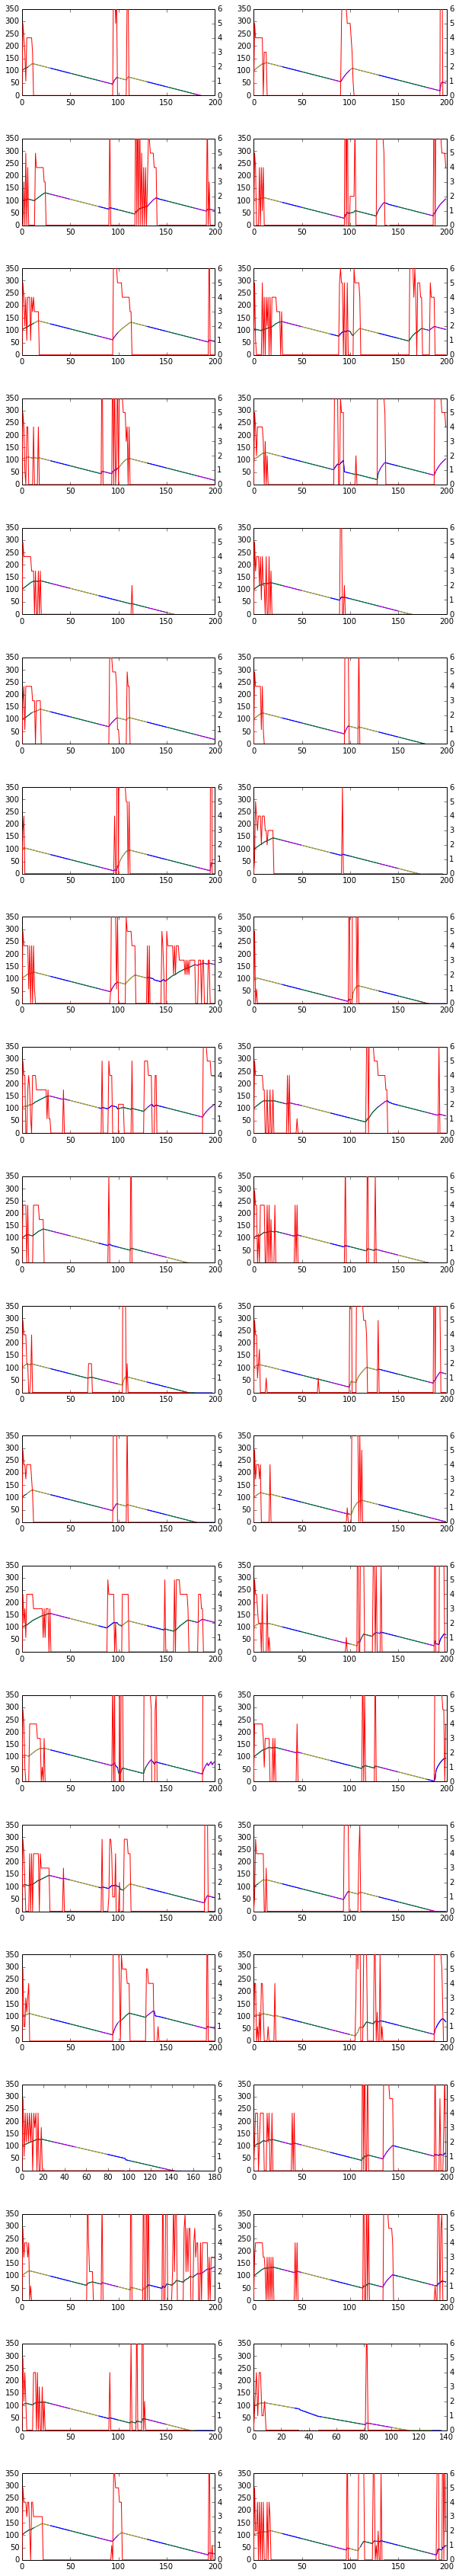

In [15]:
from matplotlib.pyplot import subplots, subplots_adjust, plot
from numpy import arange
from itertools import groupby

filtered_agents = [agent for agent in agents.values()
                   # if agent.alive
                   # if not agent.alive
                   # if agent.init_wealth < agent.wealth
                   # if agent.metabolism > 1
                   if agent.cognition == 0
                   ]
              
fig, axes = subplots(nrows=len(filtered_agents)//2
                          +len(filtered_agents)%2, 
                     ncols=2,
                     #sharey=True,
                     #sharex=True,
                     figsize=(10,len(filtered_agents)*1.5))

for i, agent in enumerate(filtered_agents):
    axes[i//2,i%2].plot(arange(0, len(agent.vitals)), [hb.wealth for hb in agent.vitals])
    x = 0
    for season, vitals in groupby(agent.vitals, lambda hb: hb.season):
        vitals = list(vitals)
        axes[i//2,i%2].plot( arange(x, x+len(vitals)), [hb.wealth for hb in vitals], 
                            {'summer': 'm-',
                             'spring': 'g-',
                             'autumn': 'y-',
                             'winter': 'b-',}.get(season, 'k-') )        
        x += len(vitals)
    axes[i//2,i%2].set_ylim(ymin=0, ymax=350)        
    
    ax = axes[i//2,i%2].twinx()
    ax.plot( arange(0, len(agent.vitals)), [hb.sugar for hb in agent.vitals], 'r-' )
    ax.set_ylim(ymin=0, ymax=6)
        
subplots_adjust(hspace=.5)    

### To Dos

In [27]:
# TODO: find a metric for overall success/failure per agent

# TODO: better use the poison

# TODO: territorial behaviour

# TODO: subclassing, SugarTile, PoisonTile, per-agent behaviour

sketch out the dynamic flowcharts!!


children can't move until a certain age
  children cry for food


hunting & gathering (for children) 
& feeding

kill other children & protect your own

create behavioural queue / flow chart

vector based mode & queue

create comodity 'wood'


